In [1]:
%load_ext autoreload
%autoreload 2
from inxss.utils_spectrum import calc_Sqw_from_Syy_Szz
from inxss.experiment import SimulatedExperiment

import torch
import numpy as np
from scipy.interpolate import RegularGridInterpolator
from scipy.ndimage import gaussian_filter

from inxss import SpectrumDataset, SpecNeuralRepr, Particle, PsiMask, OnlineVariance, linspace_2D_equidistant, calc_Sqw_from_SpinW_results
from inxss.utils_visualization import arc_arrow, rad_arrow

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm 

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = 'cpu'

torch.set_default_dtype(torch.float32)

In [2]:
from scipy.stats import pearsonr
from scipy.interpolate import interp1d
from scipy.optimize import fsolve

In [3]:
from inxss.experiment import SimulatedExperiment, NeutronExperiment

In [4]:
incident_energy = 260

In [5]:
q_grid = np.loadtxt('/pscratch/sd/z/zhantao/inxs_steering/SpinW_data/AFM_data_2023Oct29_NeutronExpParams/Qlist_0.csv', delimiter=',')
w_grid_edges = np.loadtxt('/pscratch/sd/z/zhantao/inxs_steering/SpinW_data/AFM_data_2023Oct29_NeutronExpParams/Elist_0.csv', delimiter=',')
w_grid = (w_grid_edges[1:] + w_grid_edges[:-1]) / 2

Syy = np.loadtxt('/pscratch/sd/z/zhantao/inxs_steering/SpinW_data/AFM_data_2023Oct29_NeutronExpParams/Syy_withBroadening_0.csv', delimiter=',')
Szz = np.loadtxt('/pscratch/sd/z/zhantao/inxs_steering/SpinW_data/AFM_data_2023Oct29_NeutronExpParams/Szz_withBroadening_0.csv', delimiter=',')
Sqw = torch.from_numpy(calc_Sqw_from_SpinW_results(q_grid, Syy, Szz))

In [6]:
data = torch.load(f'/pscratch/sd/z/zhantao/inxs_steering/experiment_data/summarized_neutron_data_{incident_energy:d}meV.pt')

neutron_exp = NeutronExperiment(tuple([data['grid'][_grid] for _grid in ['h_grid', 'k_grid', 'l_grid']]), data['grid']['w_grid'], data['S'])
hklw_grid = torch.moveaxis(
            torch.stack(torch.meshgrid(neutron_exp.h_grid, neutron_exp.k_grid, neutron_exp.l_grid, neutron_exp.w_grid, indexing='ij'), dim=0), 0, -1)

hklw_grid_norm = hklw_grid[...,:2].norm(dim=-1)
neutron_exp.prepare_experiment(hklw_grid)

In [7]:
sim_exp = SimulatedExperiment(q_grid, w_grid, Syy, Szz, neutron_flux=3e2)

In [8]:
s_pred = sim_exp.get_measurements_on_coords(hklw_grid).numpy()

In [9]:
output_dict = {}

In [10]:
sigmas = np.linspace(0.5, 1.8, 16)
sub_scale_factor = np.linspace(0.0, 0.8, 51)

In [11]:
inn_output = []
mid_output = []
out_output = []

for _sigma in tqdm(sigmas):
    _sigma = np.around(_sigma, 3)
    
    s_pred_sm = gaussian_filter(s_pred, sigma=_sigma)
    
    mask_exp = neutron_exp.Sqw > 1e-10
    mask_pred = (s_pred_sm > 5e-2*s_pred_sm.max()) * mask_exp.cpu().numpy()
    # mask_pred = (s_pred > 1e-2*s_pred.max()) * mask_exp.cpu().numpy()
    
    s_pred_masked = s_pred * mask_pred
    s_pred_masked_sm = s_pred_sm * mask_pred
    total_signal = neutron_exp.Sqw.cpu().numpy()
    
    q_inn_mid = 1.1441
    q_mid_out = 1.8512

    mask_inn = (hklw_grid_norm <= q_inn_mid).numpy() * mask_pred
    mask_mid = (hklw_grid_norm >  q_inn_mid).numpy() * (hklw_grid_norm <=  q_mid_out).numpy() * mask_pred
    mask_out = (hklw_grid_norm >  q_mid_out).numpy() * mask_pred
    
    
    ddv_inn = np.zeros_like(sub_scale_factor)
    ddv_mid = np.zeros_like(sub_scale_factor)
    ddv_out = np.zeros_like(sub_scale_factor)

    mask_pred_sum = ((s_pred_sm > 1e-1*s_pred_sm.max()) * mask_exp.cpu().numpy()).sum(-1).sum(-1)
    _mask = mask_pred_sum[1:-1,1:-1] > 0

    mask_inn_sum = (mask_inn.sum(-1).sum(-1)[1:-1, 1:-1] * _mask) > 0
    mask_mid_sum = (mask_mid.sum(-1).sum(-1)[1:-1, 1:-1] * _mask) > 0
    mask_out_sum = (mask_out.sum(-1).sum(-1)[1:-1, 1:-1] * _mask) > 0

    for i_scale_factor, _scale_factor in tqdm(enumerate(sub_scale_factor), total=len(sub_scale_factor)):

        background = total_signal.copy()
        background[mask_inn] = total_signal[mask_inn] - _scale_factor * s_pred_masked_sm[mask_inn]
        background[mask_mid] = total_signal[mask_mid] - _scale_factor * s_pred_masked_sm[mask_mid]
        background[mask_out] = total_signal[mask_out] - _scale_factor * s_pred_masked_sm[mask_out]

        background_hk = background.sum(-1).sum(-1)
        
        # background_hk_dh = background_hk[2:,1:-1] - 2*background_hk[1:-1,1:-1] + background_hk[:-2,1:-1]
        # background_hk_dk = background_hk[1:-1,2:] - 2*background_hk[1:-1,1:-1] + background_hk[1:-1,:-2]
        
        background_hk_dh = background_hk[2:,1:-1] - background_hk[:-2,1:-1]
        background_hk_dk = background_hk[1:-1,2:] - background_hk[1:-1,:-2]
        
        ddv_inn[i_scale_factor] = np.abs(background_hk_dh - background_hk_dk)[mask_inn_sum].mean()
        ddv_mid[i_scale_factor] = np.abs(background_hk_dh - background_hk_dk)[mask_mid_sum].mean()
        ddv_out[i_scale_factor] = np.abs(background_hk_dh - background_hk_dk)[mask_out_sum].mean()
    
    inn_output.append(ddv_inn)
    mid_output.append(ddv_mid)
    out_output.append(ddv_out)
    
    # output_dict[_sigma] = {
    #     'inn': np.asarray(ddv_inn),
    #     'mid': np.asarray(ddv_mid),
    #     'out': np.asarray(ddv_out),
    # }

output_dict['inn'] = np.asarray(inn_output)
output_dict['mid'] = np.asarray(mid_output)
output_dict['out'] = np.asarray(out_output)
output_dict['sigmas'] = np.around(sigmas, 3)
output_dict['scales'] = np.around(sub_scale_factor, 3)

100%|██████████| 16/16 [03:09<00:00, 11.83s/it]


In [12]:
i_inn, j_inn = np.where(output_dict['inn'] == output_dict['inn'].min())
i_mid, j_mid = np.where(output_dict['mid'] == output_dict['mid'].min())
i_out, j_out = np.where(output_dict['out'] == output_dict['out'].min())

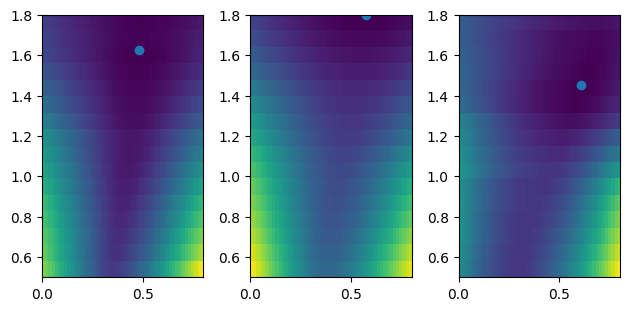

In [13]:
fig, ax = plt.subplots(1,3)
ax[0].imshow(output_dict['inn'], extent=[output_dict['scales'].min(), output_dict['scales'].max(), output_dict['sigmas'].min(), output_dict['sigmas'].max()], origin='lower')
ax[0].scatter(output_dict['scales'][j_inn], output_dict['sigmas'][i_inn])
ax[1].imshow(output_dict['mid'], extent=[output_dict['scales'].min(), output_dict['scales'].max(), output_dict['sigmas'].min(), output_dict['sigmas'].max()], origin='lower')
ax[1].scatter(output_dict['scales'][j_mid], output_dict['sigmas'][i_mid])
ax[2].imshow(output_dict['out'], extent=[output_dict['scales'].min(), output_dict['scales'].max(), output_dict['sigmas'].min(), output_dict['sigmas'].max()], origin='lower')
ax[2].scatter(output_dict['scales'][j_out], output_dict['sigmas'][i_out])
fig.tight_layout()

In [14]:
mask_exp = neutron_exp.Sqw > 1e-10
# mask_pred = (s_pred_sm > 5e-2*s_pred_sm.max()) * mask_exp.cpu().numpy()
mask_pred = (s_pred > 1e-4*s_pred.max()) * mask_exp.cpu().numpy()

s_pred_masked_sm_inn = gaussian_filter(s_pred, output_dict['sigmas'][i_inn][0]) * mask_pred
s_pred_masked_sm_mid = gaussian_filter(s_pred, output_dict['sigmas'][i_mid][0]) * mask_pred
s_pred_masked_sm_out = gaussian_filter(s_pred, output_dict['sigmas'][i_out][0]) * mask_pred

In [15]:
background = total_signal.copy()
background[mask_inn] = total_signal[mask_inn] - output_dict['scales'][j_inn][0] * s_pred_masked_sm_inn[mask_inn]
background[mask_mid] = total_signal[mask_mid] - output_dict['scales'][j_mid][0] * s_pred_masked_sm_mid[mask_mid]
background[mask_out] = total_signal[mask_out] - output_dict['scales'][j_out][0] * s_pred_masked_sm_out[mask_out]

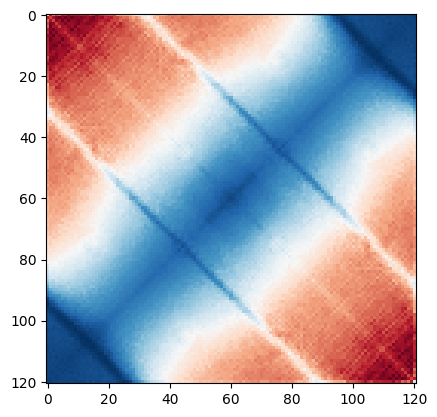

In [16]:
plt.imshow(background.sum(-1).sum(-1), cmap='RdBu_r')

In [17]:
# background = total_signal.copy()
# background[mask_inn] = total_signal[mask_inn] - best_sub_inn_scale_factor * s_pred_masked_sm[mask_inn]
# background[mask_mid] = total_signal[mask_mid] - best_sub_mid_scale_factor * s_pred_masked_sm[mask_mid]
# background[mask_out] = total_signal[mask_out] - best_sub_out_scale_factor * s_pred_masked_sm[mask_out]

# background_hk = background.sum(-1).sum(-1)

# background_hk_dh = background_hk[2:,1:-1] - 2*background_hk[1:-1,1:-1] + background_hk[:-2,1:-1]
# background_hk_dk = background_hk[1:-1,2:] - 2*background_hk[1:-1,1:-1] + background_hk[1:-1,:-2]

In [18]:
data_w_bkg = {key: val for (key, val) in data.items()}
data_w_bkg['background'] = background
data_w_bkg['background_dict'] = output_dict
torch.save(data_w_bkg, f'/pscratch/sd/z/zhantao/inxs_steering_production/experiment_data/summarized_neutron_data_w_bkg_{incident_energy:d}meV.pt')